### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


2.10.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

 # Load the training dataset

In [5]:
path = os.getcwd()
# Load the .npy file
X = np.load(path+r'\training\x_train.npy')
y = np.load(path+r'\training\y_train.npy')
print(X.shape)   #Note as sequences are already built, with window 36
print(y.shape)
print(X.dtype)
print(y.dtype)

(2429, 36, 6)
(2429,)
float64
int32


In [6]:
# visualizing X and y
print(X)
print(y)     

[[[ 1.7597e+01  8.1713e+00 -1.7842e+00 -1.9706e+01 -9.7135e+00
   -6.1887e+01]
  [ 2.2974e-01 -5.8956e+00  1.6837e+01  5.0390e+00  2.4332e+00
    5.8914e+01]
  [-2.9654e+01 -2.1296e+01  2.9103e+01 -4.7503e-01  7.5391e+01
    1.0665e+01]
  ...
  [ 1.1982e+02  2.1849e+02  1.6398e+03  5.9787e+02  2.1922e+03
    1.8484e+01]
  [ 9.1591e+01  1.0378e+02  1.8238e+03  1.2460e+03  1.1301e+04
    7.5107e+02]
  [ 4.3719e+01  3.0689e+01  9.5092e+02  8.5927e+02  8.1331e+03
    9.8883e+02]]

 [[ 2.4209e+00 -5.6039e-01  2.3654e+01 -3.8171e+00  1.3721e+00
    8.2510e+00]
  [ 1.6847e+00  2.3989e+01  1.7803e+01 -1.9575e+01 -8.2534e+00
   -2.3959e+01]
  [ 5.0692e-01  5.0281e+01  5.1196e+01  1.6036e+01  7.2974e-01
   -1.8185e+01]
  ...
  [-1.5618e+01 -7.4233e+00  3.7833e+00  1.6565e+00 -1.0438e+01
   -5.5229e+00]
  [-1.0702e+01 -6.3568e+00 -4.6464e+00  6.7957e-01 -5.5260e+00
    1.9070e+01]
  [-4.6352e+00 -3.2769e+00 -5.9048e+00 -1.9564e-01  1.1487e+00
    2.3275e+01]]

 [[ 3.9688e+01  7.0129e+02  3.0038e+

## Train-test split

In [7]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape)
print(y_train)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

(1943, 36, 6)
[3 9 6 ... 9 1 5]
(486, 36, 6)
{0: 5.996913580246914, 1: 1.6522108843537415, 2: 0.7496141975308642, 3: 0.5308743169398907, 4: 3.2383333333333333, 5: 1.3271857923497268, 6: 0.6476666666666666, 7: 2.998456790123457, 8: 1.6866319444444444, 9: 0.2603161843515541, 10: 2.611559139784946, 11: 3.9491869918699187}


In [8]:
from sklearn.preprocessing import StandardScaler
''''''
scaler_std = StandardScaler()
scaler_0 = MinMaxScaler(feature_range=(0,1))
scaler_1 = MinMaxScaler(feature_range=(-1,1))

num_instances, num_time_steps, num_features = X_train.shape
X_train = np.reshape(X_train, newshape=(-1, num_features))
X_train = scaler_1.fit_transform(X_train)
X_train = scaler_std.fit_transform(X_train)

X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_test.shape
X_test = np.reshape(X_test, newshape=(-1, num_features))
X_test = scaler_1.transform(X_test)
X_test = scaler_std.transform(X_test)

X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
print(scaler_std.__dict__)


{'with_mean': True, 'with_std': True, 'copy': True, 'n_samples_seen_': 69948, 'mean_': array([-0.81133252, -0.58569435, -0.57929294, -0.65126302, -0.67881927,
       -0.7487387 ]), 'var_': array([0.00022398, 0.0007448 , 0.00094555, 0.00092814, 0.00089061,
       0.00062569]), 'scale_': array([0.01496597, 0.02729097, 0.03074981, 0.03046538, 0.02984309,
       0.02501388])}


In [9]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(1943, 12)
(486, 12)


In [10]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

## Support functions

In [11]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

## Build the models

In [12]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 700


In [13]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = tfkl.LayerNormalization(epsilon=1e-6)(inputs)
    x = tfkl.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = tfkl.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = tfkl.LayerNormalization(epsilon=1e-6)(res)
    x = tfkl.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = tfkl.Dropout(dropout)(x)
    x = tfkl.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [14]:
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = tfk.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tfkl.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tfkl.Dense(dim, activation="relu")(x)
        x = tfkl.Dropout(mlp_dropout)(x)
    outputs = tfkl.Dense(classes, activation="softmax")(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

     # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(5e-4), metrics='accuracy')
    
    return model

In [15]:
model = build_transformer_model(
    input_shape,
    head_size=128,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 6)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 36, 6)       12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 36, 6)       6918        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [16]:
def lr_scheduler(epoch, lr, warmup_epochs=15, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True)
        ]

history= model.fit(
        X_train,
        y_train,
        validation_data = (X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
).history
# Plot results
plot_history(history)
plot_cm(model)

Epoch 1/700
61/61 [==============================] - 2s 11ms/step - loss: 2.3141 - accuracy: 0.2651 - val_loss: 2.0454 - val_accuracy: 0.3230
Epoch 2/700
61/61 [==============================] - 0s 7ms/step - loss: 2.1578 - accuracy: 0.3052 - val_loss: 2.0201 - val_accuracy: 0.3272
Epoch 3/700
61/61 [==============================] - 0s 7ms/step - loss: 2.1046 - accuracy: 0.3345 - val_loss: 2.0001 - val_accuracy: 0.3354
Epoch 4/700
61/61 [==============================] - 0s 7ms/step - loss: 2.0720 - accuracy: 0.3376 - val_loss: 1.9892 - val_accuracy: 0.3354
Epoch 5/700
61/61 [==============================] - 0s 7ms/step - loss: 2.0530 - accuracy: 0.3356 - val_loss: 1.9915 - val_accuracy: 0.3416
Epoch 6/700
61/61 [==============================] - 0s 7ms/step - loss: 2.0236 - accuracy: 0.3453 - val_loss: 1.9794 - val_accuracy: 0.3395
Epoch 7/700
61/61 [==============================] - 0s 7ms/step - loss: 1.9954 - accuracy: 0.3567 - val_loss: 1.9763 - val_accuracy: 0.3416
Epoch 8/700


KeyboardInterrupt: 

In [ ]:
model.save('gab_model')

INFO:tensorflow:Assets written to: gab_model\assets


INFO:tensorflow:Assets written to: gab_model\assets


#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [17]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    
    encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(input_layer)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]
    #
    decoder_inputs = tf.keras.layers.RepeatVector(36)(encoder_outputs2[0])
    #
    decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(6))(decoder_l2)

    # Classifier
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=False))(decoder_outputs2)
    classifier = tfkl.Dense(128, activation='relu')(bilstm)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [18]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary() #note double number of parameters (this is because we have 2 lstm)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 36, 100),    42800       ['Input[0][0]']                  
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 100),        80400       ['lstm[0][0]']                   
                                 (None, 100),                                                 

In [19]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)]
).history

Epoch 1/700
61/61 [==============================] - 8s 42ms/step - loss: 2.4178 - accuracy: 0.0587 - val_loss: 2.3160 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 2/700
61/61 [==============================] - 1s 16ms/step - loss: 2.2385 - accuracy: 0.1832 - val_loss: 2.2952 - val_accuracy: 0.0514 - lr: 0.0010
Epoch 3/700
61/61 [==============================] - 1s 16ms/step - loss: 2.1268 - accuracy: 0.1606 - val_loss: 2.2439 - val_accuracy: 0.0885 - lr: 0.0010
Epoch 4/700
61/61 [==============================] - 1s 16ms/step - loss: 2.0655 - accuracy: 0.1868 - val_loss: 2.3259 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 5/700
61/61 [==============================] - 1s 16ms/step - loss: 1.9955 - accuracy: 0.1781 - val_loss: 2.1932 - val_accuracy: 0.1564 - lr: 0.0010
Epoch 6/700
61/61 [==============================] - 1s 17ms/step - loss: 2.1912 - accuracy: 0.1127 - val_loss: 2.2483 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 7/700
61/61 [==============================] - 1s 16ms/step - lo

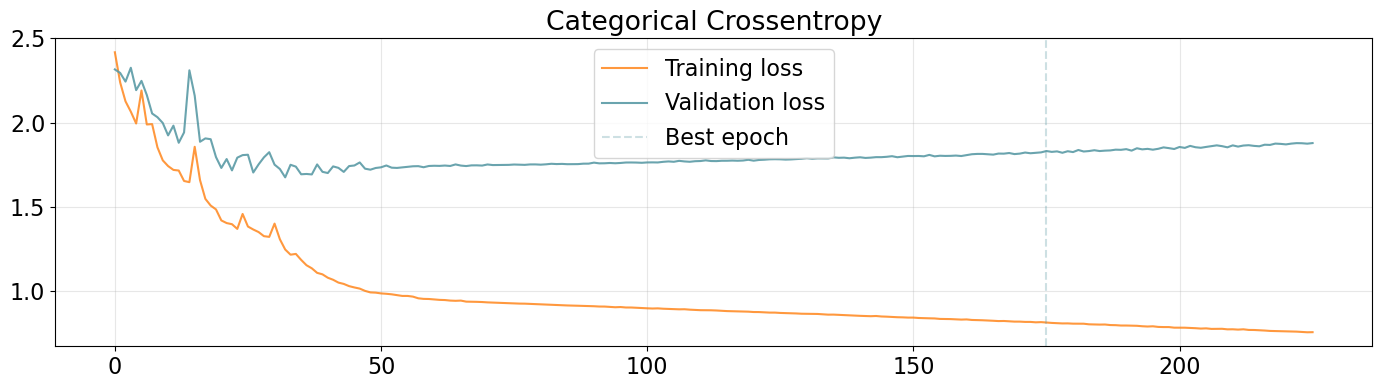

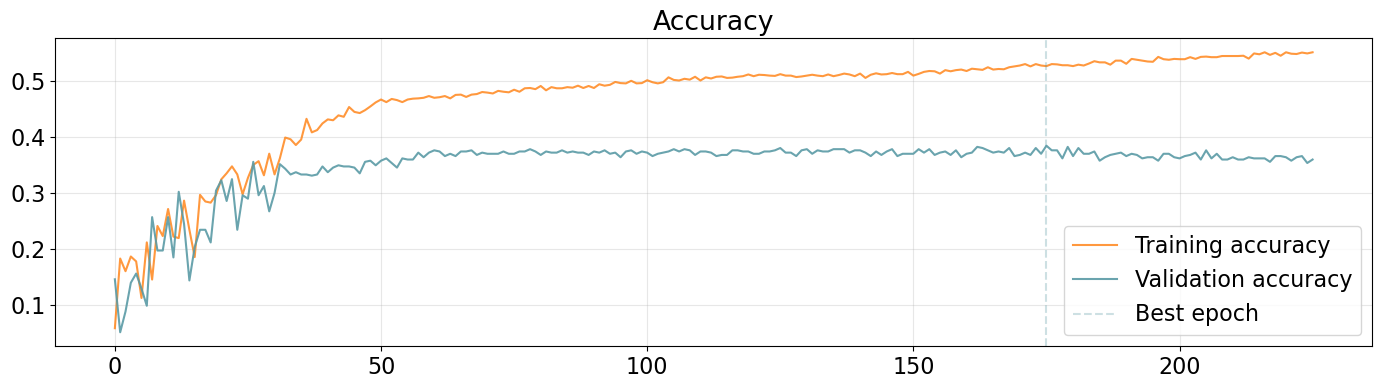

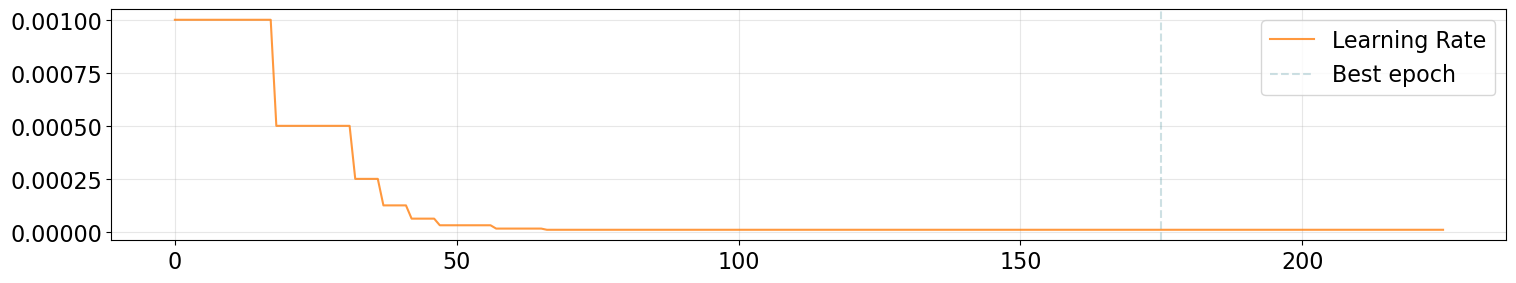

In [20]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [21]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 2s 8ms/step


(486, 12)

Accuracy: 0.3848
Precision: 0.4313
Recall: 0.455
F1: 0.4019


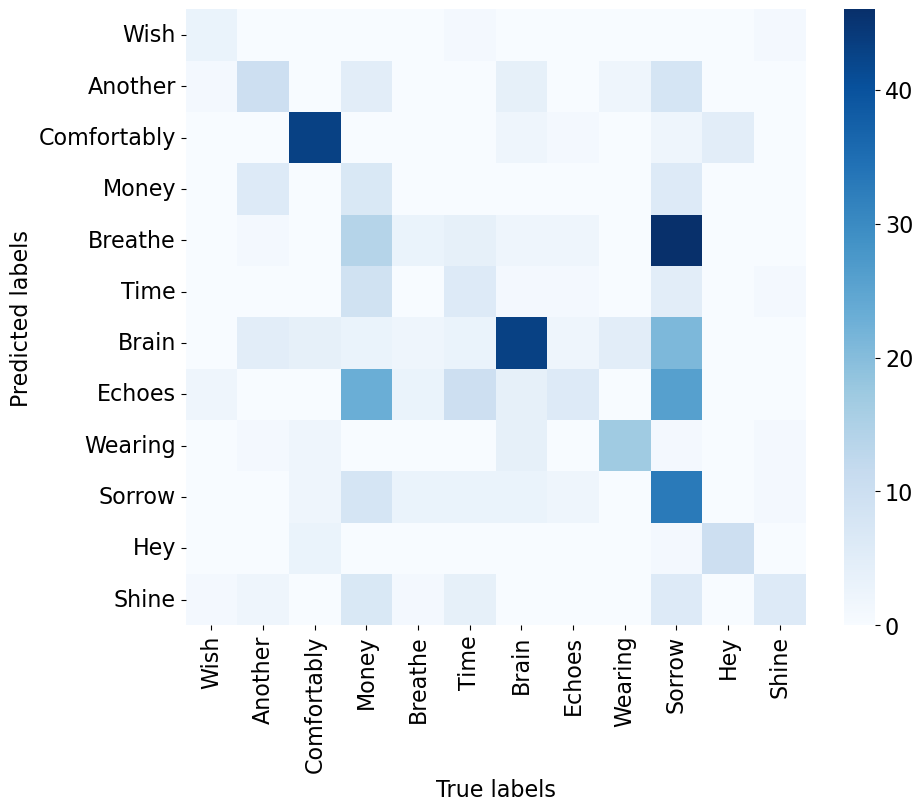

In [22]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### 1D Convolutional Neural Network

In [23]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [24]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 128)               0     

In [25]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    class_weight=class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/700
61/61 [==============================] - 1s 7ms/step - loss: 2.3506 - accuracy: 0.2007 - val_loss: 2.4046 - val_accuracy: 0.3683 - lr: 0.0010
Epoch 2/700
61/61 [==============================] - 0s 4ms/step - loss: 2.2716 - accuracy: 0.3227 - val_loss: 2.3465 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 3/700
61/61 [==============================] - 0s 4ms/step - loss: 2.2128 - accuracy: 0.3515 - val_loss: 2.2523 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 4/700
61/61 [==============================] - 0s 4ms/step - loss: 2.1186 - accuracy: 0.2373 - val_loss: 2.1686 - val_accuracy: 0.4218 - lr: 0.0010
Epoch 5/700
61/61 [==============================] - 0s 4ms/step - loss: 2.0486 - accuracy: 0.2198 - val_loss: 2.1397 - val_accuracy: 0.2387 - lr: 0.0010
Epoch 6/700
61/61 [==============================] - 0s 4ms/step - loss: 2.0563 - accuracy: 0.2254 - val_loss: 2.0471 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 7/700
61/61 [==============================] - 0s 4ms/step - loss: 1.9

KeyboardInterrupt: 

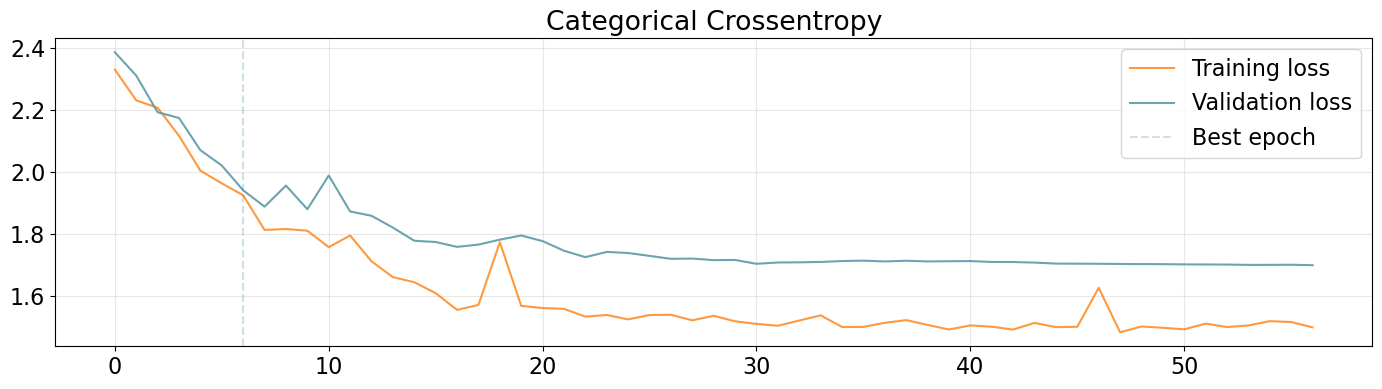

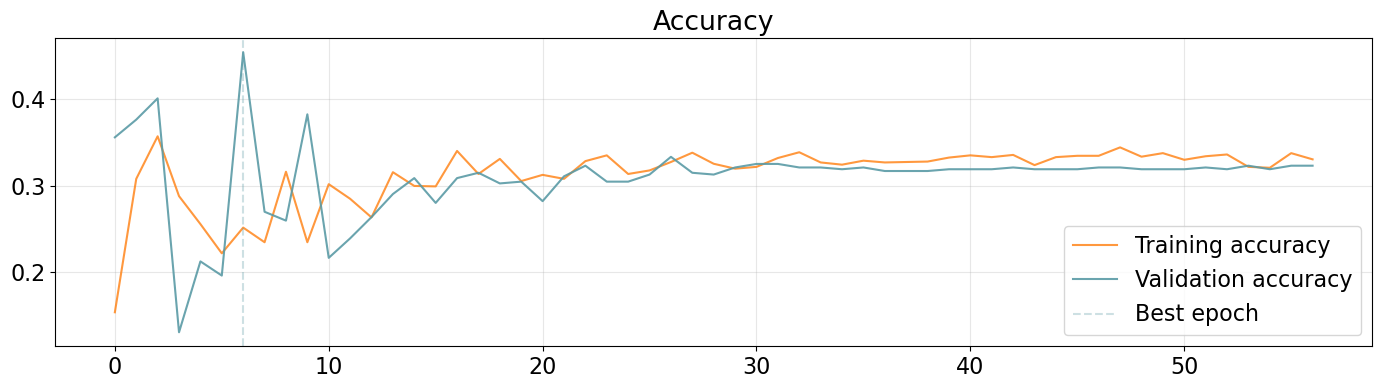

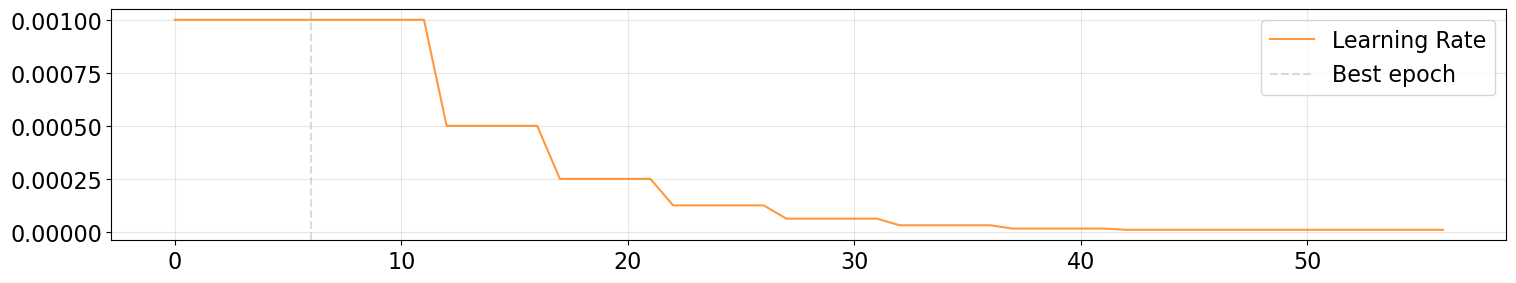

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set with the 1DCNN
predictions = model.predict(X_test)
predictions.shape

16/16 [==============================] - 0s 1ms/step


(486, 12)

Accuracy: 0.4547
Precision: 0.385
Recall: 0.3682
F1: 0.3439


c:\Users\Gabriele\miniconda3\envs\gputensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


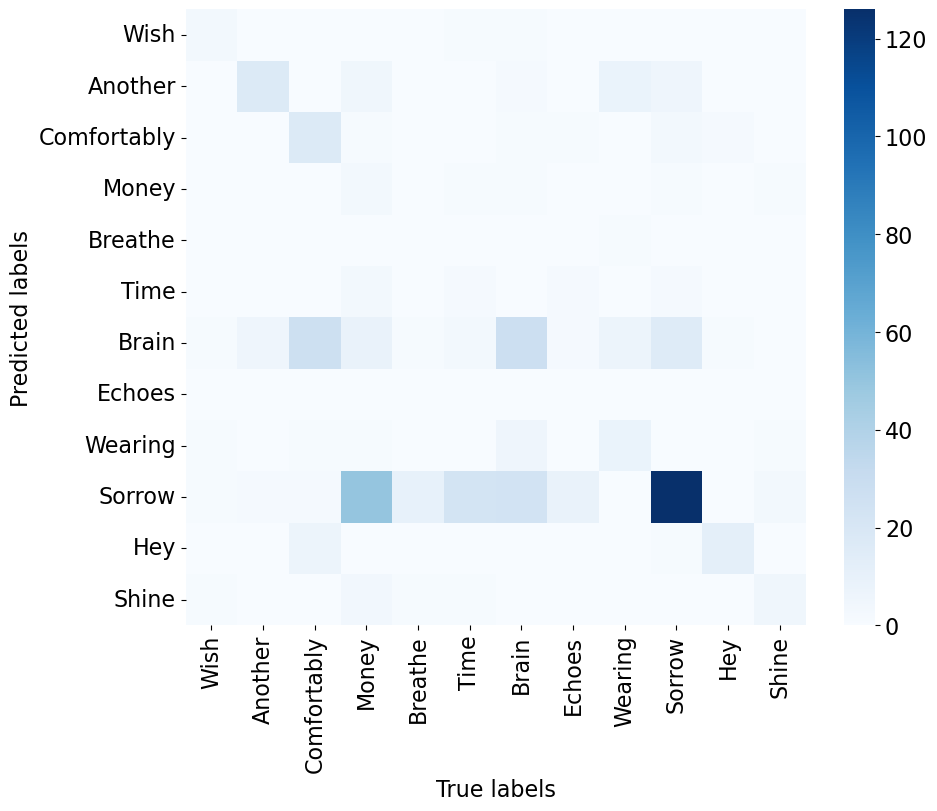

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()